In [1]:
using Pkg
for p in ["Knet", "Plots", "IterTools","PyCall"]
    if !haskey(Pkg.installed(),p)
        Pkg.add(p);
    end
end
using DelimitedFiles
using Knet: KnetArray, accuracy, progress, minibatch, cycle, adam, sgd
using Plots
using IterTools: ncycle, takenth, take
using Base.Iterators: flatten
using LinearAlgebra

include("utils.jl")
include("utils2.jl")
include("models.jl")

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at none:0
└ @ Core none:0
┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at none:0
└ @ Core none:0


In [2]:
adj, features, labels, idx_train, idx_val, idx_test = load_dataset("pubmed")

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 1.0; 0.0 0.0 … 1.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Int32[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 1:140, 200:499, [2692, 2532, 2050, 1715, 2362, 2609, 2622, 1975, 2081, 1767  …  1885, 2305, 2354, 2135, 2601, 1770, 1995, 2504, 1749, 2157])

In [3]:
# TODO: take user inputs
struct args
    epochs
    lr
    weight_decay
    hidden
    pdrop
end

arguments = args(200, 0.01, 5e-4, 16, 0.5)

# Model and optimizer
model = GCN(size(features,1),
            arguments.hidden,
            size(labels,2),
            adj,
            arguments.pdrop)

#(g::GCN)(x,y) = nll(g(x)[:, idx_train], y[idx_train]) + (arguments.weight_decay * sum(g.layer1.w .* g.layer1.w)) 
(g::GCN)(x,y) = nll(g(x)[:, idx_train], y[idx_train])

In [4]:
output = model(features)

7×2708 Array{Float32,2}:
  0.579778   0.46976     2.25304   …   0.183975    1.12264    0.762287
  0.268981  -0.441714   -2.70198       0.0554833  -0.623758  -1.71986 
  0.48013   -0.3996      3.10413       0.228829   -0.334136   0.409158
  0.959933   0.846392    5.80377       0.233078    0.433106   1.01558 
  0.108842   0.138248    0.361531     -0.0245054   0.450485   1.12525 
 -0.740321  -0.98363    -6.15859   …  -0.125426   -0.538799  -3.47725 
  0.396743  -0.0180696   0.208066     -0.02987    -0.716787  -0.827117

In [5]:
labels_decoded = mapslices(argmax, labels ,dims=2)[:]

2708-element Array{Int64,1}:
 4
 5
 5
 1
 4
 3
 1
 4
 4
 3
 1
 1
 5
 ⋮
 4
 4
 4
 4
 4
 4
 1
 4
 4
 4
 4
 4

In [6]:
nll(output[:,idx_train], labels_decoded[idx_train])

2.6612124f0

In [7]:
accuracy(output[:,idx_train], labels_decoded[idx_train])

0.18571428571428572

In [8]:
using AutoGrad
J = @diff model(features, labels_decoded)
grad(J, params(model)[1])

16×1433 Array{Float32,2}:
 -0.000824162  -0.00182515  -0.00483662  …  -0.0124904   -0.00596719 
  0.00358073   -0.236511    -0.102171        0.0411073   -0.00983443 
  0.0323394     0.0748771    0.111458        0.0746539    0.0145421  
  0.0208491     0.135998     0.0842307       0.0205035   -0.0122978  
  0.024518      0.00802783  -0.00706878      0.0275784    0.0228897  
  0.0662343     0.0502889    0.150608    …   0.0433969   -0.0155074  
  0.00275134   -0.00504356   0.0230389       0.0483609   -0.000697833
  0.0638657     0.163779     0.150438        0.00928316   0.00414632 
  0.00182825    0.508615     0.31634         0.0466829   -0.0044823  
  0.00167612    0.0256201    0.0254036       0.0136985   -0.00133996 
  2.76735e-5    0.010157     0.0326048   …   0.01374     -0.00839452 
  0.000678877  -0.00285596   0.0316662       0.0209202    0.0127084  
 -0.00351536    0.187871     0.0133593       0.0867853    0.0026272  
  0.0283946    -0.109789    -0.00388389      0.0685921    0.0311

In [9]:
dtrn =  minibatch(features, labels_decoded[:], length(labels_decoded))

Data{Tuple{Array{Float32,2},Array{Int64,1}}}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [4 5 … 4 4], 2708, 2708, false, 1, 1:2708, false, (1433, 2708), (2708,), Array{Float32,2}, Array{Int64,1})

In [10]:
function train_with_results(model, dtrn, epoch, lr)
    training = adam(model, ncycle(dtrn, epoch), lr=lr)
    snapshot() = model(dtrn)
    snapshots = (snapshot() for x in takenth(progress(training),length(dtrn)))
    res = collect(flatten(snapshots))
    return res
end

train_with_results (generic function with 1 method)

┣████████████████████┫ [100.00%, 200/200, 00:24/00:24, 8.50i/s] 


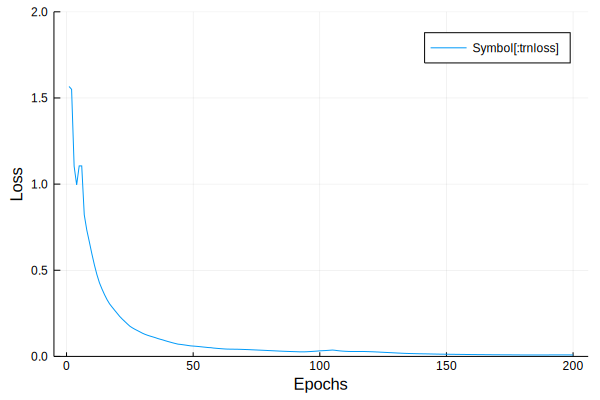

In [11]:
results = train_with_results(model, dtrn, arguments.epochs, arguments.lr)
trnloss = Array{Float32}(results)
plot(trnloss, ylim=(0.0,2.0),labels=[:trnloss],xlabel="Epochs",ylabel="Loss")

In [12]:
output = model(features)
accuracy(output[:,idx_train], labels_decoded[idx_train])

1.0

In [13]:
output = model(features)
accuracy(output[:,idx_test], labels_decoded[idx_test])

0.72

In [14]:
adj, features, labels, idx_train, idx_val, idx_test = load_dataset("citeseer")

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 1.0; 0.0 0.0 … 1.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Int32[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 1:140, 200:499, [2692, 2532, 2050, 1715, 2362, 2609, 2622, 1975, 2081, 1767  …  1885, 2305, 2354, 2135, 2601, 1770, 1995, 2504, 1749, 2157])

In [15]:
# TODO: take user inputs
struct args
    epochs
    lr
    weight_decay
    hidden
    pdrop
end

arguments = args(200, 0.01, 5e-4, 16, 0.5)

# Model and optimizer
model = GCN(size(features,1),
            arguments.hidden,
            size(labels,2),
            adj,
            arguments.pdrop)

#(g::GCN)(x,y) = nll(g(x)[:, idx_train], y[idx_train]) + (arguments.weight_decay * sum(g.layer1.w .* g.layer1.w)) 
(g::GCN)(x,y) = nll(g(x)[:, idx_train], y[idx_train])

In [16]:
output = model(features)

7×2708 Array{Float32,2}:
 -0.324352   0.301272  -0.274594   0.0606106  …  -0.488238     -1.2224  
 -0.351604  -0.89069   -1.53901   -0.0103354      0.0939331    -0.391322
 -0.196443   0.75171    1.64551    0.0829296      0.32347       1.26141 
 -0.162155  -0.114089   2.2271    -0.0746152      0.000278719   1.08391 
  0.624536   1.08294    7.50994    0.0326087      1.72492       6.51265 
 -0.417153  -0.265094  -0.82246   -0.0255931  …  -0.520281     -2.33852 
 -1.37294   -1.26282   -4.70707    0.18757       -0.623363     -2.20768 

In [17]:
labels_decoded = mapslices(argmax, labels ,dims=2)[:]

2708-element Array{Int64,1}:
 4
 5
 5
 1
 4
 3
 1
 4
 4
 3
 1
 1
 5
 ⋮
 4
 4
 4
 4
 4
 4
 1
 4
 4
 4
 4
 4

In [18]:
nll(output[:,idx_train], labels_decoded[idx_train])

3.66165f0

In [19]:
accuracy(output[:,idx_train], labels_decoded[idx_train])

0.15

In [20]:
using AutoGrad
J = @diff model(features, labels_decoded)
grad(J, params(model)[1])

16×1433 Array{Float32,2}:
 -0.00930923   -0.0652798  -0.00180868  …   0.00860939  -0.0441679  
  0.032705      0.148099    0.165657        0.057688    -0.000774094
  0.00335203    0.0         0.0121872      -0.00244632   0.0424741  
  0.0504619     0.590003    0.272317        0.0338004    0.0538025  
  0.00706997   -0.440124   -0.247463       -0.0235806   -0.0708594  
  0.0370851     0.124793    0.0779606   …   0.0658095    0.0335021  
  0.0143789     0.0708167   0.0256226      -0.00308335   0.0273438  
  0.0278905     0.122331    0.118845        0.036346     0.0136638  
 -0.000405386   0.0956977  -0.0046278       0.0264278    0.0613638  
 -0.0340539    -0.0781205  -0.0528174       0.0243622   -0.00663339 
  0.0204725     0.0583648   0.0291887   …   0.0389757    0.0263794  
  0.0218962     0.0744729   0.142107        0.102423     0.119165   
 -0.000815128  -0.0405303  -0.0173468      -0.0304544   -0.00693737 
 -0.0260919    -0.036761    0.0139637      -0.0347322   -0.00301641 
  0.0928

In [21]:
dtrn =  minibatch(features, labels_decoded[:], length(labels_decoded))

Data{Tuple{Array{Float32,2},Array{Int64,1}}}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [4 5 … 4 4], 2708, 2708, false, 1, 1:2708, false, (1433, 2708), (2708,), Array{Float32,2}, Array{Int64,1})

In [22]:
function train_with_results(model, dtrn, epoch, lr)
    training = adam(model, ncycle(dtrn, epoch), lr=lr)
    snapshot() = model(dtrn)
    snapshots = (snapshot() for x in takenth(progress(training),length(dtrn)))
    res = collect(flatten(snapshots))
    return res
end

train_with_results (generic function with 1 method)

┣████████████████████┫ [100.00%, 200/200, 00:21/00:21, 9.33i/s] 


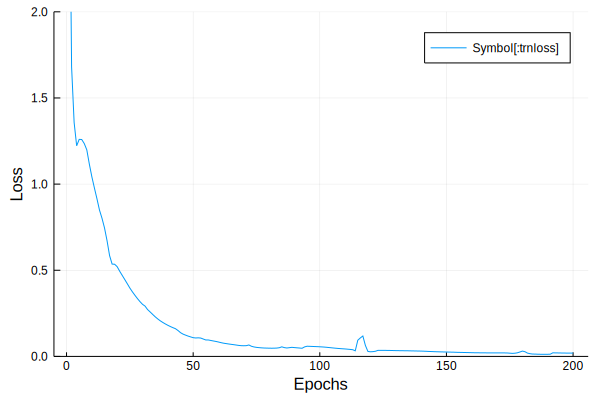

In [23]:
results = train_with_results(model, dtrn, arguments.epochs, arguments.lr)
trnloss = Array{Float32}(results)
plot(trnloss, ylim=(0.0,2.0),labels=[:trnloss],xlabel="Epochs",ylabel="Loss")

In [24]:
output = model(features)
accuracy(output[:,idx_train], labels_decoded[idx_train])

1.0

In [25]:
output = model(features)
accuracy(output[:,idx_test], labels_decoded[idx_test])

0.728